# Introduction to the BAREFOOT Framework
## A Bayesian Optimization Framework for Optimization of Multi-Fidelity Models

In [1]:
# First: Some necessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pickle import dump, load
from gpModel import gp_model
from reificationFusion import model_reification
from mechModels import isostrain_IS, isostress_IS, isowork_IS, TC_GP
from copy import deepcopy

### 3) The BAREFOOT Framework

The BAREFOOT Framework, taken from the phrase "<font color=blue><b>Ba</b></font>tch <font color=blue><b>Re</b></font>ification/<font color=blue><b>F</b></font>usi<font color=blue><b>o</b></font>n <font color=blue><b>O</b></font>p<font color=blue><b>t</b></font>imization Framework", is a framework developed for multi-fidelity Batch Bayesian Optimization \[1\]. While the framework has been developed and tested in a materials design and optimization setting, the framework is applicable to any situation where there are multiple models available for the prediction of an objective value. At this point, the framework is only configured for single-objective optimization, however, we are currently developing the capability to do multi-objective optimization. 

As the name suggests, the framework combines the two approaches that have already been discussed. We have published the results from the initial framework testing approach in JOM, and the code associated with that work has been uploaded to Code Ocean with a small example. For more up-to-date code, we are actively developing the code and putting latest working versions of the code on Github.

The aim of the framework is to facilitate the easy deployment of design optimization that can provide advantages from both multi-fidelity optimization and Batch Bayesian Optimization. The framework is built in Python, does not require any significantly advanced Python modules to be imported and can run on High Performance Computing Resources with ease. To run the framework there are only 2 things that are essential:

1) A selection of reduced order models

2) A Ground Truth model (this can also be an actual experiment)

An overview of the framework approach is shown in the Figure below:

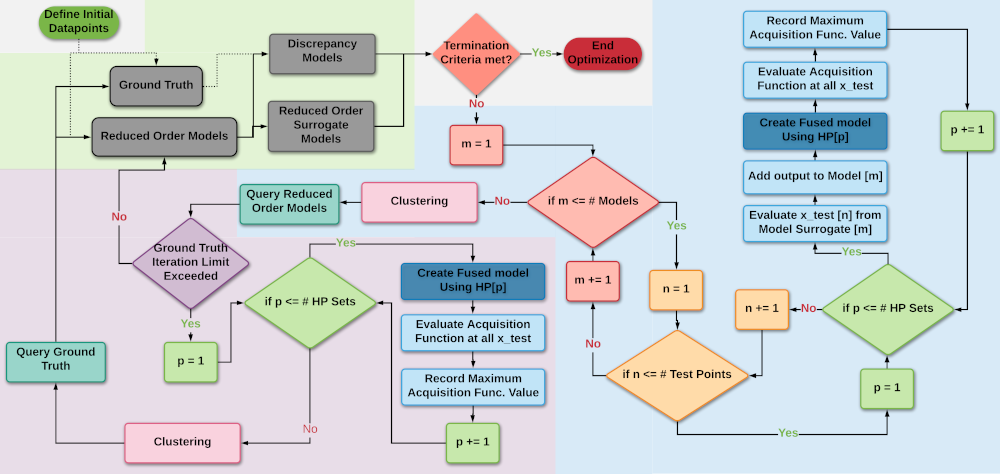

Following the initial setup of the reduced order, and discrepancy model GPs, the approach of the framework has two stages:

#### Reduced Order Model Evaluations (light blue background)
In this stage, we evaluate the acquisition functions to determine which reduced order models we will query.

1) choose a reduced order model

2) evaluate the test points from that reduced order model GP

3) build new fused models using each hyperparameter set after temporarily updating the reduced order model GP with one of the values from the test points

4) evaluate the acquisition function for this combination of reduced order model, test point and hyperparameter set

5) repeat steps 1-4 until all combinations of reduced order model, test point and hyperparameter set have been tested

6) Take the results from 5 and cluster using acquisition function value, model index and test point index as inputs to the k-medoids algorithm

7) Each medoid will contain a model and test point that will then be queried from the reduced order models

#### Truth Model Evaluations (light purple background)
The approach here is similar, but since we only want to query from the Truth Model, we don't need to worry about iterating over the reduced order models.

1) Build fused GP with hyperparameter set "i"

2) Evaluate acquisition function at all test points

3) repeat steps 1-2 until all hyperparameter sets have been used

4) cluster the results using k-medoids

5) evaluate medoids from Truth Model

In this version of the framework, the batch size is set at the number of Truth Model queries that can be evaluated simultaneously. There are numerous parameters that can be set when operating the framework. And at the moment there is a selection of 6 acquisition functions that can be used:

* Expected Improvement
* Thompson Sampling
* Knowledge Gradient
* Probability of Improvement
* Upper Confidence Bound
* Greedy (Max-Value)

The framework is initialized in a two stage process. The first sets up the framework with general information. The parameters that can be edited are:

* ROMModelList : This is the list of functions that are the cheap information sources. These need to be in a form that ensures that by providing the unit hypercube input, the function will provide the required output
* TruthModel : This is the Truth model, or the function that needs to be optimized.
* calcInitData : This variable controls whether the initial data is calculated for each of the models or is retrieved from a file
* initDataPathorNum : This variable holds the number of initial datapoints to evaluate for each information source (including the Truth Model), or, when initial data is loaded from a file, holds the path to the initial data file
* multiNode : This variable reflects the number of subprocesses that will be used for the calculations. A value of zero indicates all calculations will be completed on the main compute node.
* workingDir : This is the path to the working directory. In some cases it may be desirable to store data separately from the code, this will allow the data to be stored in alternate locations. Can also be used if the relative directory reference is not working correctly.
* calculationName : This is the name for the calculation and will change the results directory name
* nDim : The number of dimensions for the input space that will be used
* restore_calc : This parameter toggles whether the framework data is set up from the information provided or retrieved from a save_state file. This can be used to restart a calculation
* updateROMafterTM : This parameter allows the reduced order models to be retrained after getting more data from the Truth Model. The model function calls do not change, so the training needs to reflect in the same function.
* externalTM : In cases where it is necessary to evaluate the Truth Model separate to the framework (for example, if the Truth Model is an actual experiment), this toggles the output of the predicted points to a separate file for use externally. The framework is shut down after the data is output, see test examples for how to restart the framework after the external Truth Model has been evaluated
* acquisitionFunc : The acquisition function to use to evaluate the next best points for the reduced order models. Currently the options are "KG" for Knowledge Gradient and "EI" for expected improvement.
* A, b, Aeq, beq: Equality and inequality constraints according to the following equations:
  * A*x <= b
  * Aeq*x == b
* ub, lb : Upper bounds and lower bounds for inputs, all inputs must receive a value (Specify 0 for lb and 1 for ub if there is no bound for that input)
* func : function constraints, must take the input matrix (x) and output a vector of length equal to the number of samples in the input matrix (x) with boolean values.
* keepSubRunning : Determines whether the subprocesses are left running while calling the Truth Model
* verbose : Determines the logging level for tracking the calculations.

The second stage sets up the specific calculation required:

* modelParam : This is a dictionary of hyperparameters for the low-order model GPs and the discrepancy GPs. See example below for dictionary structure.
* covFunc : Choice of covariance function for building GP models. Choices are currently limited to Squared Exponential ("SE"), Matern 3/2 ("M32"), and Matern 5/2 ("M52").
* iterLimit : This determines the total number of iterations that the calculation will run for.
* sampleCount : The number of test samples to use. Samples are selected by Latin Hypercube Sampling.
* hpCount : The number of hyperparameter sets to use.
* batchSize : The batch size for the evaluations of the real functions. This affects both the number of reduced order evaluations and the number of Truth Function evaluations.
* tmIter : The iteration limit before calling the Truth Function.
* totalBudget : The total budget (calculation time) that can be expended before the framework is terminated.
* tmBudget : The amount of budget that needs to be used before the Truth Function is evaluated.
* upperBound : The upper bound of the hyperparameters (usually setting to 1 is sufficient since inputs are on a unit hypercube).
* lowBound : The lower bound of the hypeparameter values.
* fusedPoints : The number of points per dimension to use when constructing the Fused GP. Points for evaluating the Fused GP are sampled linearly for each dimension, creating a grid of points to evaluate the fused mean and variance.


As can be seen, there are many parameters that can be set. Most of these parameters have defaults that have been determined through extensive testing of the framework and will be updated should further testing prove there are better values that can be used. 

### FInal Note on implementation in this nanoHUB Tool
The framework has been developed for use on cluster resources, and more specifically in a non-interactive environment. The code supplied with this tool has a modification that allows it to run in an interactive Python environment and will be suitable for small test cases. However, for larger, or more complex problems, it would be advisable to obtain the latest version of the code from the Github Repository \[3\].

### Example Demonstration of BAREFOOT Optimization

Again, in this demonstration we will be using a set of mechanical models that were used in the published work on the framework. In this application, the aim was to optimize the normalized strain hardening rate $(1/\sigma(d\sigma/d\epsilon_{pl}))$. 

#### Reduced Order Models:
##### Isowork
The isowork model is a simple empirical model that assumes that the work is evenly distributed between the two phases of a material.

##### Isostrain
The isostrain model assumes thas the strain is distributed in an identical manner in the two phases

##### Isostress
The isostress model assumes that the stress is identical in both phases.

As can be seen in the figures below, each of these models provides a poor estimate of the Finite Element Model ground truth. 

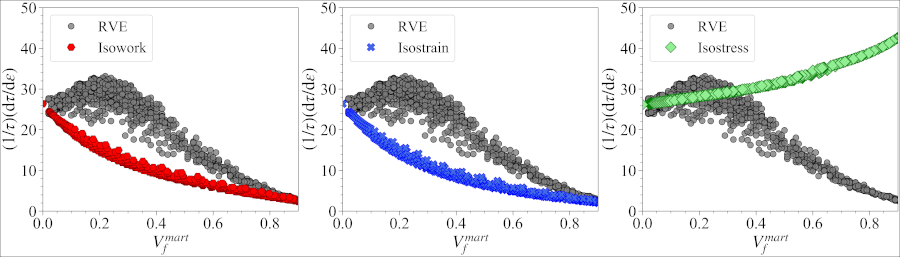

As for the reification case study, we need to use Thermo-Calc to determine the volume fraction and composition of the ferrite and martensite phases. However, since we don't have access to the Thermo-Calc license on this system, there is a GP that is able to predict the volume fraction and composition of the ferrite and martensite phases. This GP has been trained on the output from Thermo-Calc and the specific details for how the GP is constructed can be found in our previous work. The next block of code creates the Thermo-Calc Gaussian Process model, and because it can take some time, we pickle the GP object and save it for easier recall later.

In [2]:
with open("data/tc_gpObj.pkl", 'rb') as f:
    tc_gp = load(f)

The next three functions are the reduced order models that we will use in the framework. The general structure required for these models is that they need to take a single input which is a vector or array with the design points from the unit hypercube of the design space, and must output a vector of results from each set of design points.

In [3]:
def call_isowork(x_in):
    ep = 0.009
    if len(x_in.shape) == 1:
        x_in = np.expand_dims(x_in, axis=0)
    x = np.ones((x_in.shape[0],4))
    x[:,0] = 200*x_in[:,0] + 650
    x[:,1] = x_in[:,1]
    x[:,2] = x[:,2]*0.283
    x[:,3] = x[:,3]*0.328
    with open("data/tc_gpObj.pkl", 'rb') as f:
        tc_gp = load(f)
    tc_out = tc_gp.predict(x)
    return isowork_IS(tc_out, ep)

def call_isostrain(x_in):
    ep = 0.009
    if len(x_in.shape) == 1:
        x_in = np.expand_dims(x_in, axis=0)
    x = np.ones((x_in.shape[0],4))
    x[:,0] = 200*x_in[:,0] + 650
    x[:,1] = x_in[:,1]
    x[:,2] = x[:,2]*0.283
    x[:,3] = x[:,3]*0.328
    with open("data/tc_gpObj.pkl", 'rb') as f:
        tc_gp = load(f)
    tc_out = tc_gp.predict(x)
    return isostrain_IS(tc_out, ep)

def call_isostress(x_in):
    ep = 0.009
    if len(x_in.shape) == 1:
        x_in = np.expand_dims(x_in, axis=0)
    x = np.ones((x_in.shape[0],4))
    x[:,0] = 200*x_in[:,0] + 650
    x[:,1] = x_in[:,1]
    x[:,2] = x[:,2]*0.283
    x[:,3] = x[:,3]*0.328
    with open("data/tc_gpObj.pkl", 'rb') as f:
        tc_gp = load(f)
    tc_out = tc_gp.predict(x)
    return isostress_IS(tc_out, ep)

class RVE_GP():
    def __init__(self):
        self.mean = 0
        self.std = 0
        self.gp = 0
        self.setup()
        
    def setup(self):
        data = pd.read_excel('./data/rve_data.xlsx')
        data.iloc[:,0] = (data.iloc[:,0]-650)/200
        data.iloc[:,2] = data.iloc[:,2]/3
        data.iloc[:,3] = data.iloc[:,3]/2
        self.mean = np.mean(data.iloc[:,5])
        self.std = np.std(data.iloc[:,5])
        data.iloc[:,5] = (data.iloc[:,5]-self.mean)/self.std
        self.gp = gp_model(data.iloc[:,0:4], data.iloc[:,5], np.array([0.12274117, 0.08612411, 0.65729583, 0.23342798]), 0.16578065, 0.1, 4, 'SE')

    def predict(self, x_predict):
        if len(x_predict.shape) == 1:
            x_predict = np.expand_dims(x_predict, axis=0)
        x = np.ones((x_predict.shape[0],4))        
        x[:,0] = x_predict[:,0]           #Temperature
        x[:,1] = x_predict[:,1]           #wt% C
        x[:,2] = x[:,2]*0.283/2           #wt% Si
        x[:,3] = x[:,3]*0.328/3           #wt% Mn
        mean, var = self.gp.predict_var(x)
        
        return (mean*self.std + self.mean)

rve_gp = RVE_GP() 


Due to the nature of the framework, namely the use of the concurrent.futures module for running calculations in parallel, it is not possible to run the framework code directly from a Jupyter Notebook. Therefore, we will need to start the framework running by calling a console command from the Notebook. However, before we do that, we will start by going through the setup required for the calculation.

In order to use the framework, we first need to import the barefoot class

In [4]:
from barefoot import barefoot

In this case, we again need to define a list of reduced order models as well as the Truth Model. In this case, we define the truth model as the RVE Class Function that actually makes the prediction. This is because the Framework will call the Truth Model function with given inputs and expect a list of outputs for each input.

In [5]:
ROMList = [call_isowork, call_isostrain, call_isostress]
truthmodel = rve_gp.predict

As shown above, the BAREFOOT Framework is initialized in two stages. The first stage is the initialization of the barefoot Python Class. Some of the more essential parameters that can be specified are shown in the call below. The output from this code includes an interactive plot that will be updated when the framework calculation starts, as well as the first few lines of what is normally output to the log file. This log file is used to track the progress of the framework calculation.

<IPython.core.display.Javascript object>


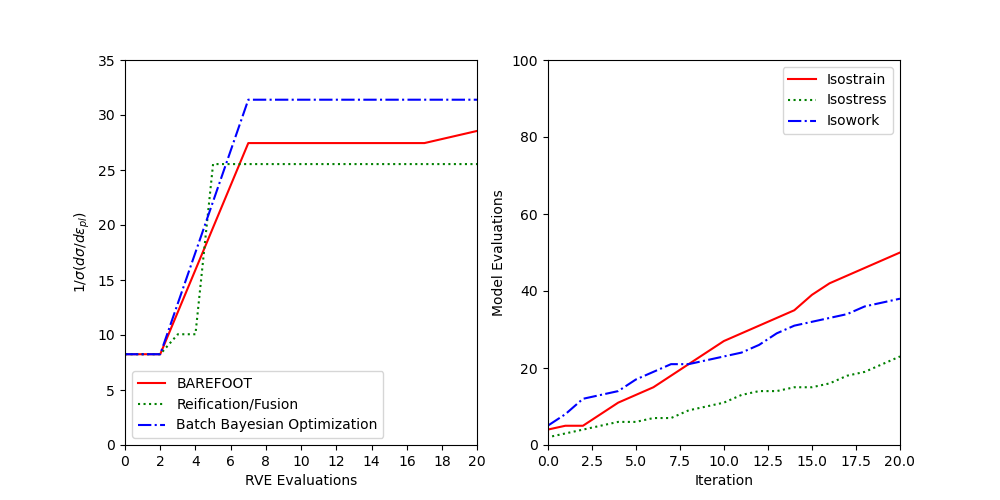

2021-08-05 10:52:53,843 - barefoot - INFO - #########################################################
2021-08-05 10:52:53,844 - barefoot - INFO - #                                                       #
2021-08-05 10:52:53,845 - barefoot - INFO - #        Start BAREFOOT Framework Initialization        #
2021-08-05 10:52:53,845 - barefoot - INFO - #                                                       #
2021-08-05 10:52:53,846 - barefoot - INFO - #########################################################
2021-08-05 10:52:53,846 - barefoot - INFO - *********************************************************
2021-08-05 10:52:53,847 - barefoot - INFO - * Calculation Name: barefoot   
2021-08-05 10:52:53,847 - barefoot - INFO - *********************************************************
2021-08-05 10:52:53,852 - barefoot - INFO - Initialization Completed


[[0.9 0.9]
 [0.8 0.8]]
[3.52933424 8.25243108]


In [6]:
%matplotlib notebook
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].set_xlabel('RVE Evaluations')
ax[0].set_ylabel('$1/\sigma(d\sigma/d\epsilon_{pl})$')
ax[0].set_xlim(0,20)
ax[0].set_xticks([0,2,4,6,8,10,12,14,16,18,20])
ax[0].set_ylim(0,35)
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Model Evaluations')
ax[1].set_xlim(0,20)
ax[1].set_ylim(0,100)

framework = barefoot(ROMModelList=ROMList, TruthModel=truthmodel, 
                    calcInitData=False, initDataPathorNum="data/initData.pickle", nDim=2, 
                    calculationName="barefoot", acquisitionFunc="EI",
                    restore_calc=False, logname="barefoot", tmSampleOpt="EI", temp_input=[fig, ax])

As with the reification/Fusion approach, we need to define the model hyperparameters. In the case of the BAREFOOT Framework, we need to supply the dictionary as defined previously, with one additional set of parameters. This set is the cost for each of the individual models. This cost is used to calculate how much to remove from the budget if the optimization is to be budget limited, but is more critically used to modify the acquisition function to push the framework to utilize less expensive models to expend less budget over the course of the optimization.

In [7]:
modelParam = {'model_l': [[0.1,0.1],[0.1,0.1],[0.1,0.1]],
                  'model_sf': [1,1,1],
                  'model_sn': [0.01, 0.01, 0.01],
                  'means': [0,0,0],
                  'std': [1,1,1],
                  'err_l': [[0.1,0.1],[0.1,0.1],[0.1,0.1]],
                  'err_sf': [1,1,1],
                  'err_sn': [0.01, 0.01, 0.01],
                  'costs': [1,2,3, 5000]}

The second stage of the framework initialization is a call to the initialize_parameters function. And this function call determines many of the calculation parameters. Again, the Github repository has a full list of the available options that can be set.

In [8]:
framework.initialize_parameters(modelParam=modelParam, covFunc="SE", iterLimit=20,  
                                      sampleCount=20, hpCount=25, batchSize=5, 
                                      tmIter=5, upperBound=1, lowBound=0.0001, fusedPoints=10)

2021-08-05 10:52:57,829 - barefoot - INFO - Reification Object Initialized. Ready for Calculations


True

At this point, it is worth noting that the BAREFOOT Framework has not been developed for interactive computing environments, and so will likely perform in a sub-optimal manner.

The framework makes use of the concurrent.futures module to handle the asynchronous calculations. The code on Github uses "ProcessPoolExecutor" which has been found in our testing to be the best way to run the asynchronous calculations. The code attached to this Notebook has been modified to use the "ThreadPoolExecutor". The main reason for this change is that "ProcessPoolExecutor" is incompatible with interactive kernels and so if the code was left unchanged it would not be possible to run the framework code. Using "ThreadPoolExecutor" has no real effect on the calculations in the current Notebook. However, when testing the asynchronous operation the "ProcessPoolExecutor" was found to work better with larger datasets and particularly with large dimension problems. I believe that this is related to the size of the matrices that are generated as the data size and dimensionality increases. 

To start the calculation we can use the single command below.

In [9]:
framework.run_optimization()

2021-08-05 10:53:09,650 - barefoot - INFO - Start Full BAREFOOT Framework Calculation
2021-08-05 10:53:09,651 - barefoot - INFO - #########################################################
2021-08-05 10:53:09,652 - barefoot - INFO - #                Start Iteration : 0000                 #
2021-08-05 10:53:09,652 - barefoot - INFO - #########################################################
2021-08-05 10:53:09,665 - barefoot - INFO - Start Acquisition Function Evaluations for 1500 Parameter Sets
2021-08-05 10:53:15,488 - barefoot - INFO - Acquisition Function Evaluations Completed
2021-08-05 10:53:15,492 - barefoot - INFO - Clustering of Acquisition Function Evaluations Completed
2021-08-05 10:53:15,493 - barefoot - INFO - Start ROM Function Evaluations | 5 Calculations
2021-08-05 10:53:25,030 - barefoot - INFO - ROM Function Evaluations Completed
 C:\Users\richa\Anaconda3\envs\main\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning:Creating an ndarray from ragged ne

2021-08-05 10:54:58,596 - barefoot - INFO - Start Acquisition Function Evaluations for 1500 Parameter Sets
2021-08-05 10:55:05,409 - barefoot - INFO - Acquisition Function Evaluations Completed
2021-08-05 10:55:05,414 - barefoot - INFO - Clustering of Acquisition Function Evaluations Completed
2021-08-05 10:55:05,415 - barefoot - INFO - Start ROM Function Evaluations | 5 Calculations
2021-08-05 10:55:15,102 - barefoot - INFO - ROM Function Evaluations Completed
2021-08-05 10:55:15,399 - barefoot - INFO - Dataframes Pickled and Dumped to Results Directory
2021-08-05 10:55:15,422 - barefoot - INFO - Calculation State Saved
2021-08-05 10:55:15,422 - barefoot - INFO - Iteration 7 Completed Successfully
2021-08-05 10:55:15,423 - barefoot - INFO - #########################################################
2021-08-05 10:55:15,423 - barefoot - INFO - #                Start Iteration : 0008                 #
2021-08-05 10:55:15,424 - barefoot - INFO - ############################################

2021-08-05 10:57:21,492 - barefoot - INFO - #########################################################
2021-08-05 10:57:21,492 - barefoot - INFO - #                Start Iteration : 0015                 #
2021-08-05 10:57:21,493 - barefoot - INFO - #########################################################
2021-08-05 10:57:21,511 - barefoot - INFO - Start Acquisition Function Evaluations for 1500 Parameter Sets
2021-08-05 10:57:37,977 - barefoot - INFO - Acquisition Function Evaluations Completed
2021-08-05 10:57:37,988 - barefoot - INFO - Clustering of Acquisition Function Evaluations Completed
2021-08-05 10:57:37,989 - barefoot - INFO - Start ROM Function Evaluations | 5 Calculations
2021-08-05 10:57:46,947 - barefoot - INFO - ROM Function Evaluations Completed
2021-08-05 10:57:46,948 - barefoot - INFO - Start Truth Model Evaluations
2021-08-05 10:57:46,969 - barefoot - INFO - Start Max Value Calculations | 25 Sets
2021-08-05 10:57:47,982 - barefoot - INFO - Max Value Calculations Comp

True

The normal setup of the BAREFOOT Framework, does not come with interactive plotting. But the code attached to this Notebook has had that functionality added. Going back up to the framework initialization step will show the interactive plot. The output from the code in the block above is what would normally be output to a log file. This output shows the progress of the code and can be used to track the code while it is running.

What will be quite easy to notice is that the combined approach does take a little while longer for each iteration. This is mainly a factor of combining the two approaches. If we wish to use 100 sets of hyperparameters for the Batch Optimization approach, and we have 3 reduced order models, that we want to evaluate at 50 sample points, there will be a total of $100 \times 3 \times 50 = 15,000$ calculations that need to be completed.

Due to this, the framework is configured to allow the calculations to run on subprocess nodes as well. In this case, the framework is able to work significantly faster since it is possible to expand the calculations to as many nodes as are required and then all those calculations are done concurrently. 

This has been done separately again to ensure that we have 30 calculations with the required parameters. In this case, we have used the equivalent inputs from both the Riefication/Fusion and Batch Bayesian Optimization approaches. The results are compared with the previous results below.

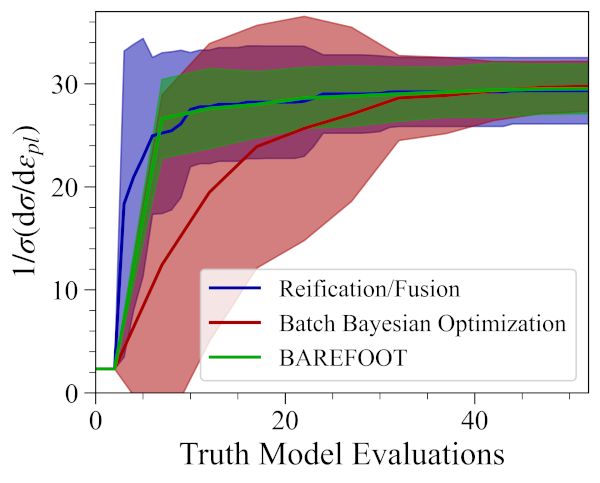

As we can see, the combined framework performs at a similar level to the Reification/Fusion method alone, but has lower variance and slightly larger mean. However, this analysis is only half of the picture. This plot shows how consistently the algorithm performs and is a requirement to show that the uncertainty in the result from the framework is smaller than either of the two individual optimization approaches.
    
As before, this comparison doesn't show the true power of the BAREFOOT Approach. As we can see above, the BAREFOOT approach optimizes significantly faster than the pure Batch Bayesian Optimization approach, and when we consider the time for the optimization (shown below) we can see that the BAREFOOT Approach completes within the same time as the Batch Bayesian Optimization approach.

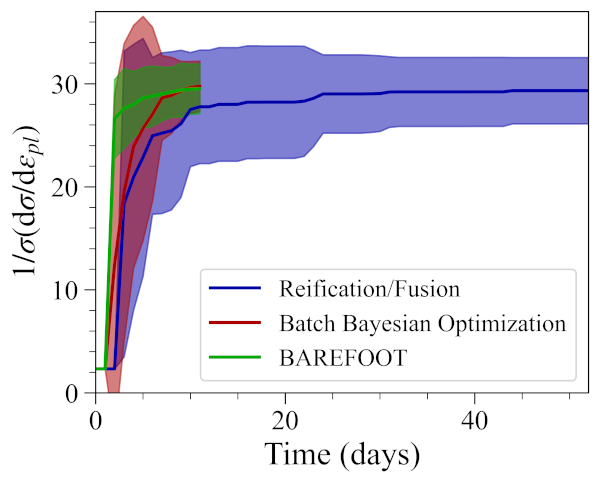
    
As a final note, we can tune this performance by increasing the batch size. And our previous results show that it is possible to improve the performance quite significantly by doing this. These results are presented in our published work on the framework and will be expanded on in future publications. 

As a final note there is an early version of the code (the version that was used to calculate the results in our paper) that has been posted to the Code Ocean Repository \[2\]. The code is still under active development and has changed quite significantly since the version of code posted on Code Ocean. To stay up-to-date with all the changes, please go to our Github Repository \[3\]

## References

\[1\] Couperthwaite, Richard, Abhilash Molkeri, Danial Khatamsaz, Ankit Srivastava, Douglas Allaire, and Raymundo Arroyave. “Materials Design Through Batch Bayesian Optimization with Multisource Information Fusion.” JOM, October 13, 2020. https://doi.org/10.1007/s11837-020-04396-x.

\[2\] Richard Couperthwaite, Raymundo Arroyave, Abhilash Molkeri, Danial Khatamsaz, Ankit Srivastava, Douglas Allaire (2021) BAREFOOT Framework [Source Code]. https://doi.org/10.24433/CO.7729810.v1

\[3\] https://github.com/RichardCouperthwaite/BAREFOOT-Framework
